1KG
==
Run mushi on 3-SFS computed from 1000 Genome Project data

In [1]:
%matplotlib inline 
#%matplotlib notebook
import histories
import mushi
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import expit
import time
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../

/Users/williamdewitt/Desktop/repos/dement/stdpopsim
/Users/williamdewitt/Desktop/repos/dement


### Load 1KG 3-SFS

In [2]:
ksfs_CEU = pd.read_csv('1KG/scons_output/3-SFS.tsv', sep='\t', index_col=0)

mutation_types = ksfs_CEU.columns
ksfs_CEU

,AAA>ACA,AAA>AGA,AAA>ATA,AAC>ACC,AAC>AGC,AAC>ATC,AAG>ACG,AAG>AGG,AAG>ATG,AAT>ACT,...,TCA>TTA,TCC>TAC,TCC>TGC,TCC>TTC,TCG>TAG,TCG>TGG,TCG>TTG,TCT>TAT,TCT>TGT,TCT>TTT
sample frequency,,,,,,,,,,,,,,,,,,,,,
1,20122,34442,12116,7525,24025,6199,10632,25011,5757,10163,...,37740,11869,11767,44135,2439,2723,48924,17880,23492,42602
2,5279,9287,3255,1927,6193,1711,2386,6459,1380,2567,...,10075,3162,3092,13727,637,780,12788,4604,6104,12095
3,3303,5645,2008,1154,3836,1045,1478,4150,872,1578,...,6364,1857,1915,8528,385,458,7717,2671,3781,7290
4,2425,4208,1432,766,2886,760,1070,3059,592,1142,...,4432,1383,1335,6063,269,361,5334,1998,2810,5219
5,1866,3166,1145,625,2227,543,782,2317,489,876,...,3485,997,1099,4572,229,261,4188,1555,2129,3990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,74,140,48,26,85,21,26,88,23,26,...,132,30,44,127,9,15,129,52,92,145
194,83,160,60,23,106,40,35,111,17,42,...,122,44,43,158,8,15,170,55,83,153
195,100,156,53,29,97,20,34,117,17,42,...,138,48,43,143,12,10,159,71,97,137


Rank plot of the number of SNPs of each triplet mutation type

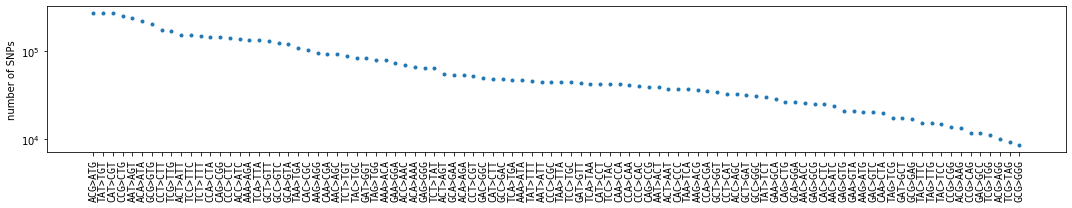

In [3]:
plt.figure(figsize=(15, 3))
plt.plot(ksfs_CEU.sum().sort_values(ascending=False).to_frame(), '.')
plt.xticks(rotation='vertical', family='monospace')
plt.ylabel('number of SNPs')
plt.yscale('symlog')
plt.tight_layout()
plt.savefig('/Users/williamdewitt/Downloads/foo.png')
plt.show()

In [4]:
# plt.style.use('dark_background')

### Demographic history $\eta(t)$ from the European population in Tennessen et al.

In [5]:
t = np.logspace(0, np.log10(3e4), 300)

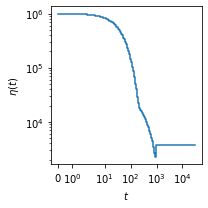

In [6]:
model = homo_sapiens.TennessenTwoPopOutOfAfrica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η = histories.η(t, y)

plt.figure(figsize=(3, 3))
η.plot()
plt.show()

### Mushi $k$-SFS object conditioned on this demographic history

In [7]:
ksfs = mushi.kSFS(η, X=ksfs_CEU.values, mutation_types=mutation_types)

### TMRCA CDF

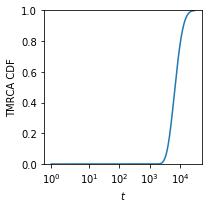

In [8]:
plt.figure(figsize=(3, 3))
plt.plot(η.change_points, ksfs.tmrca_cdf())
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Mutation type enrichment traces, as in Harris and Pritchard

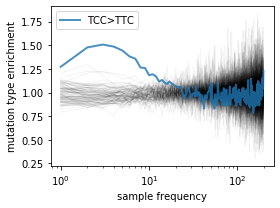

In [9]:
plt.figure(figsize=(4, 3))
foo = ksfs_CEU
foo = foo / foo.values.sum(1, keepdims=True)
foo = foo / foo.mean(0)
plt.plot(foo, c='k', lw=1, alpha=0.05)
plt.plot(foo['TCC>TTC'], label='TCC>TTC', c='C0', lw=2, alpha=0.8)
plt.xlabel('sample frequency')
plt.ylabel('mutation type enrichment')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

### Mutation type enrichment again, but as a heatmap with correlation clustering

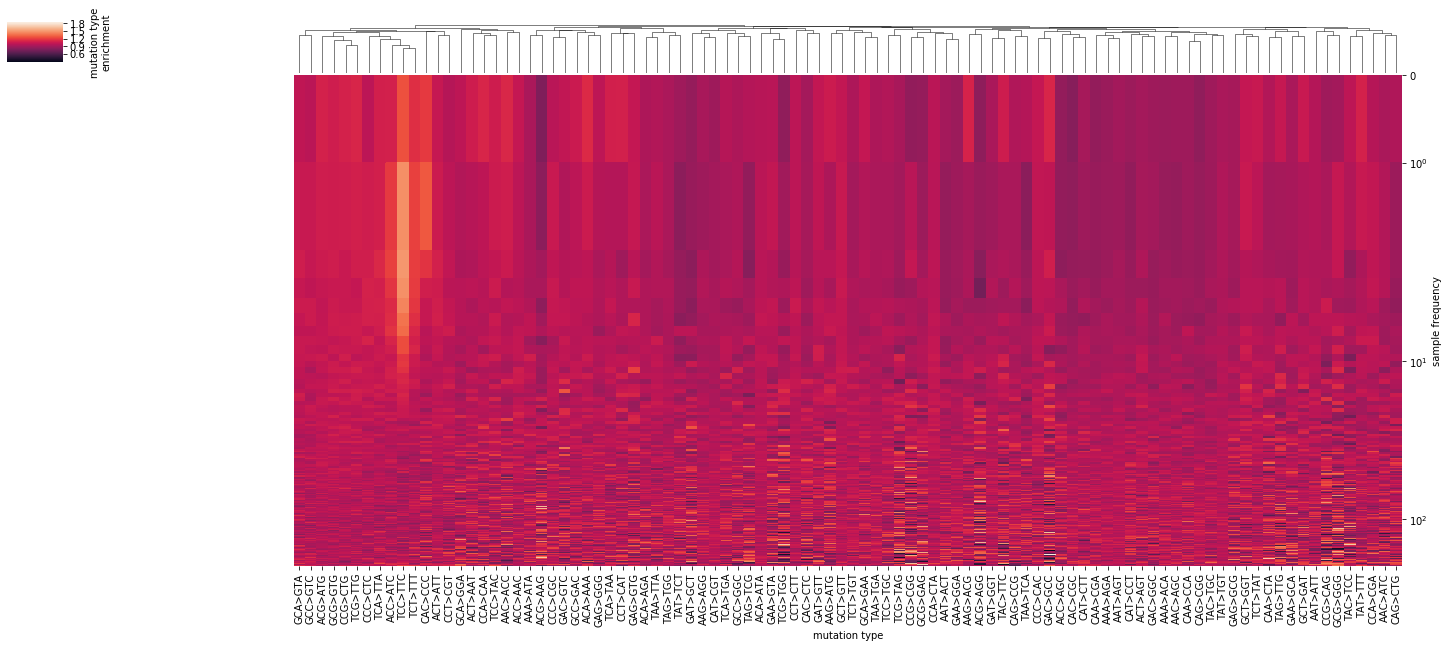

In [10]:
ksfs.clustermap(figsize=(25, 10))
plt.show()

### Invert the $k$-SFS conditioned on $\eta(t)$ to get $\boldsymbol\mu(t)$
Accelerated proximal gradient descent

In [11]:
μ_inferred, f_trajectory = ksfs.infer_μ(# loss function parameters
                                        fit='prf',
                                        exclude_singletons=False,
                                        bins=None,
                                        # time derivative regularization parameters
                                        λ_tv=1e2,
                                        α_tv=0,
                                        # spectral regularization parameters
                                        λ_r=0,
                                        α_r=1,
                                        hard=True,                                        
                                        # convergence parameters
                                        max_iter=10000,
                                        tol=1e-10,
                                        γ=0.8)

/Users/williamdewitt/Desktop/repos/dement/utils.py:63: RuntimeWarning: overflow encountered in matmul
  Ξ = L @ Z
/Users/williamdewitt/Applications/miniconda2/envs/mushi/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:523: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
/Users/williamdewitt/Desktop/repos/dement/mushi.py:197: RuntimeWarning: invalid value encountered in matmul
  + (λ_r / 2) * (1 - α_r) * (Z ** 2).sum()
/Users/williamdewitt/Desktop/repos/dement/mushi.py:197: RuntimeWarning: overflow encountered in square
  + (λ_r / 2) * (1 - α_r) * (Z ** 2).sum()
/Users/williamdewitt/Desktop/repos/dement/mushi.py:197: RuntimeWarning: invalid value encountered in double_scalars
  + (λ_r / 2) * (1 - α_r) * (Z ** 2).sum()
/Users/williamdewitt/Applications/miniconda2/envs/mushi/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, i

maximum iteration 10000 reached with relative change in loss function 2.1e-09


Convergence

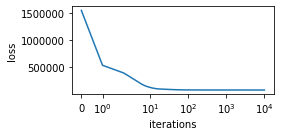

In [12]:
plt.figure(figsize=(4, 2))
plt.plot(f_trajectory)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.xscale('symlog')
plt.tight_layout()
plt.show()

The inferred histories for each mutation type (raw mutation rate in units of mutations per genome per generation)

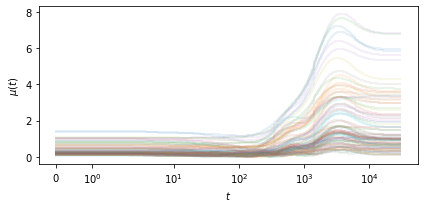

In [13]:
plt.figure(figsize=(6, 3))
μ_inferred.plot(alpha=0.1, lw=2)
plt.show()
# plt.savefig('/Users/williamdewitt/Downloads/mu.pdf', transparent=True)

Heatmap of the inferred mutation spectrum history, plotted as relative mutation intensity as in Harris and Pritchard

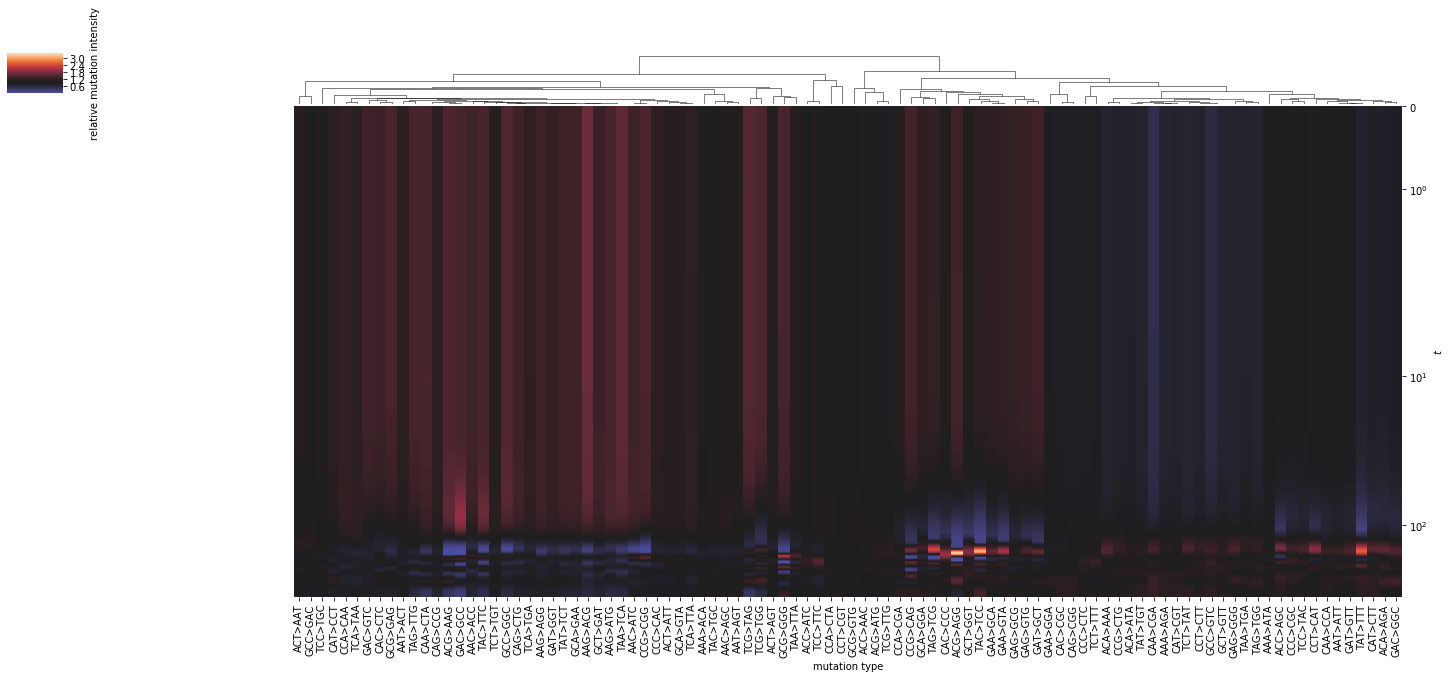

In [14]:
μ_inferred.clustermap(figsize=(25, 10))
plt.show()

plot $\chi^2$ goodness of fit for each $k$-SFS matrix element, and compute $\chi^2$ goodness of fit test for the $k$-SFS matrix as a whole

χ² goodness of fit 27199.22301746809, p = 5.7577798747101e-310


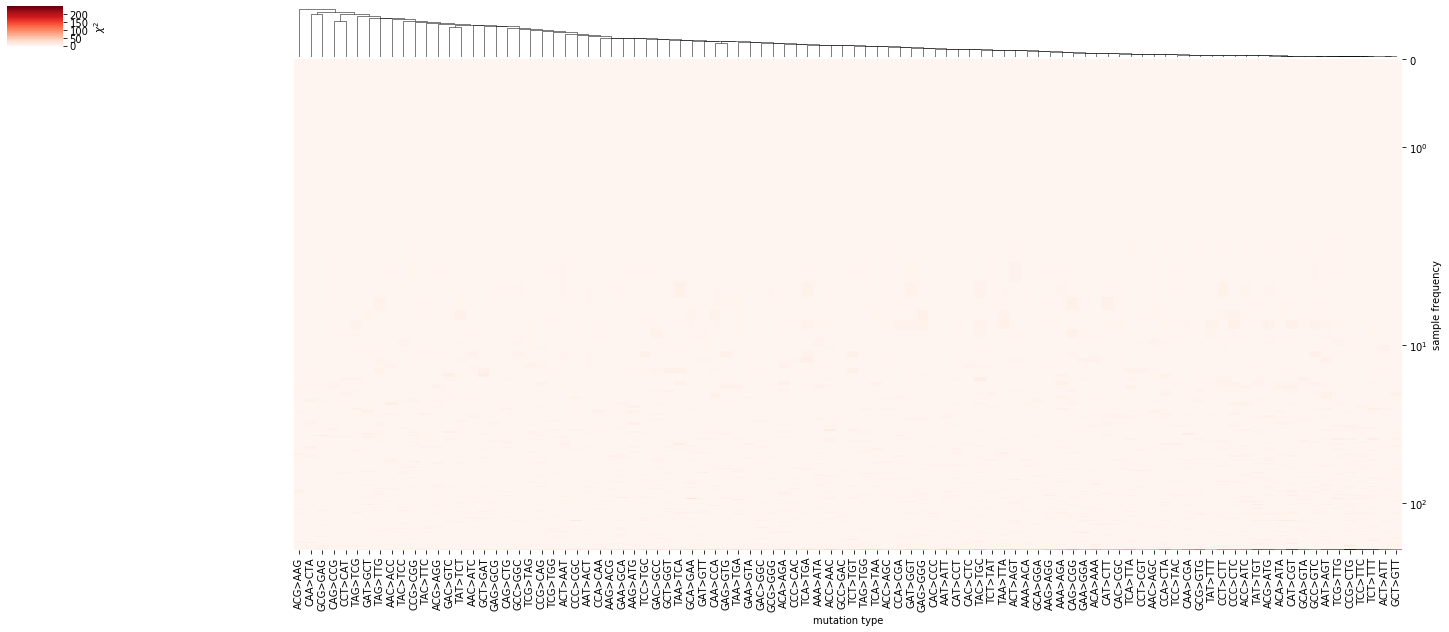

In [15]:
ksfs.clustermap(μ_inferred, figsize=(25, 10), cmap='Reds')
plt.show()

Plot SFS fit for the first 10 mutation types individually

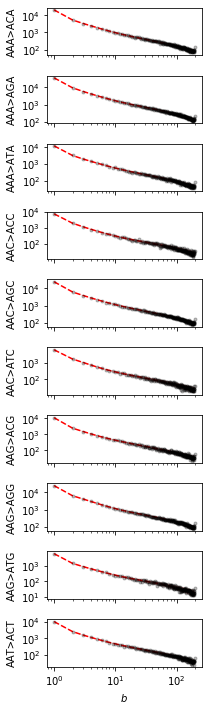

In [16]:
f, axes = plt.subplots(10, 1, sharex=True, figsize=(3, 10))
for ct, i in enumerate(range(10)):
    plt.sca(axes[ct])
    ksfs.plot(i, μ=μ_inferred, prf_quantiles=True)
    plt.ylabel(μ_inferred.mutation_types[ct])
    if ct < 9:
        plt.xlabel(None)
plt.tight_layout()
plt.show()

### Singular value spectrum of $Z$

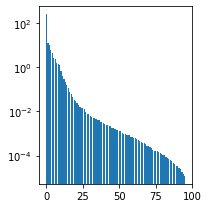

In [17]:
plt.figure(figsize=(3, 3))
plt.bar(range(μ_inferred.Z.shape[1]), np.linalg.svd(μ_inferred.Z, compute_uv=False))
plt.yscale('log')
plt.tight_layout()
plt.show()